In [1]:
from dl import queryClient as qc
import pandas as pd
from dl.helpers.utils import convert
import matplotlib.pyplot as plt
import numpy as np

In [29]:
# Set up basic query
# ra, dec, radius = 286, 45, 1
ra, dec, radius = 60, -47, 3
# ra, dec, radius = 168, 11, 0.4
query =[f"""SELECT gs.source_id, gs.ra, gs.dec, gs.g_rp, gs.bp_g, gs.bp_rp,
        gs.phot_g_mean_mag, gs.pm, gs.pmra, gs.pmdec,
        trac.ls_id, trac.mag_g, trac.mag_r, trac.mag_i, trac.mag_z,
        trac.snr_g, trac.snr_r, trac.snr_i, trac.snr_z
        FROM gaia_dr3.gaia_source AS gs
        INNER JOIN ls_dr10.tractor as trac ON trac.ref_id=gs.source_id
        WHERE trac.type='PSF'
        AND trac.mag_r < 19 AND trac.mag_r > 16
        AND gs.pm < 10 AND gs.pm > 1
        AND (q3c_radial_query(trac.ra,trac.dec,{ra},{dec},{radius}))
        ORDER BY trac.random_id
        LIMIT 20000"""]
# Join full query
query = ''.join(query)

# Send query to NOIRlab
result = qc.query(sql=query) # result as string
data = convert(result, "pandas") # result as dataframe

In [37]:
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True, subset=['bp_rp', 'pm', 'pmra', 'pmdec', 
                                  'mag_g', 'mag_r', 'mag_i', 'mag_z'])
data.sort_values('bp_rp', inplace=True)
data.to_csv('gaia_calib.csv', index=False)

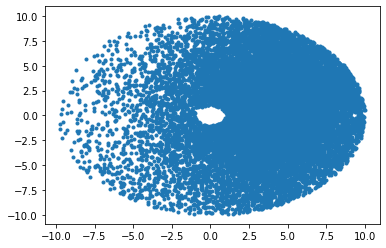

In [31]:
plt.plot(data['pmra'], data['pmdec'], '.')

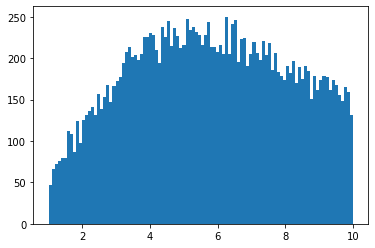

In [32]:
_ = plt.hist(data.pm, bins=100)

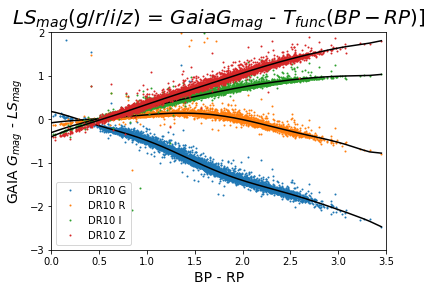

In [39]:
gaia_G = data['phot_g_mean_mag']
desi_bands = ['mag_g', 'mag_r', 'mag_i', 'mag_z']
xlim = [0, 3.5]
ylim = [-3, 2]
funcs = []
for b in desi_bands:
    plt.plot(data['bp_rp'], gaia_G - data[b], '.', ms=2, label=f'DR10 {b[-1].upper()}')
    
    coeff = np.polyfit(np.array(data['bp_rp']), np.array(gaia_G - data[b]), 10)
    x = data['bp_rp']
    y = np.zeros_like(x)
    for i,w in enumerate(coeff):
        order = len(coeff)-1-i
        y += w * x**order
    plt.plot(x, y, 'k')
    funcs.append(y)

plt.xlim(xlim)
plt.ylim(ylim)

plt.legend()
plt.xlabel("BP - RP", fontsize=14)
plt.ylabel("GAIA $G_{mag}$ - $LS_{mag}$", fontsize=14)
plt.title("$LS_{mag}(g/r/i/z)$ = $GaiaG_{mag}$ - $T_{func}(BP - RP)$]", fontsize=20)
plt.savefig('figs/gaia_calib.png', bbox_inches='tight')
plt.show()

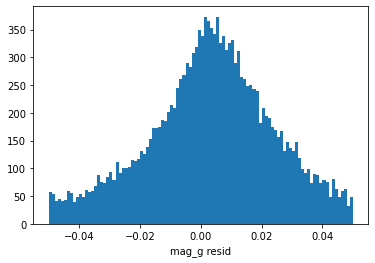

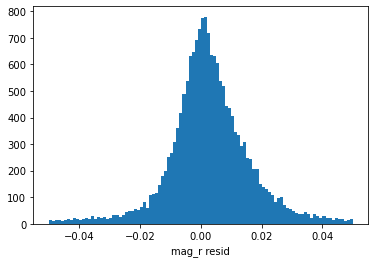

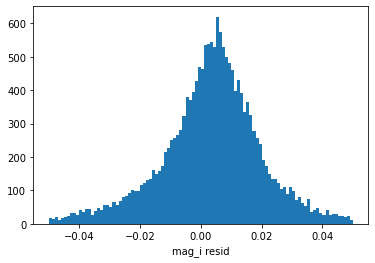

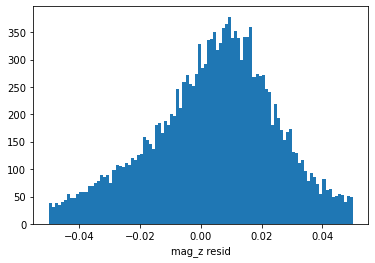

In [41]:
for i,b in enumerate(desi_bands):
    plt.hist(funcs[i]-(gaia_G-data[b]), bins=100, range=[-.05, .05])
    plt.xlabel(f'{b} resid')
    plt.savefig(f'figs/{b}_resid.png', bbox_inches='tight')
    plt.show()

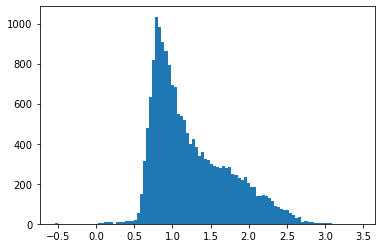

In [36]:
plt.hist(data['bp_rp'], bins=100)
plt.show()